In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [5]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def build_1d_cnn_custom_BN_2(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [10]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN_2(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 1024000)           4096000   
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 12.3858 - acc: 0.1909
Epoch 00001: val_loss improved from inf to 12.25245, saving model to model/checkpoint/1D_CNN_1_conv_custom_BN_2_checkpoint/001-12.2525.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 12.3858 - acc: 0.1909 - val_loss: 12.2525 - val_acc: 0.2010
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.3848 - acc: 0.2674
Epoch 00002: val_loss improved from 12.25245 to 11.73878, saving model to model/checkpoint/1D_CNN_1_conv_custom_BN_2_checkpoint/002-11.7388.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 11.3850 - acc: 0.2674 - val_loss: 11.7388 - val_acc: 0.2416
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 10.9297 - acc: 0.2986
Epoch 00003: val_loss did not improve from 11.73878
36805/36805 [==

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.5613 - acc: 0.5826
Epoch 00028: val_loss did not improve from 10.34619
36805/36805 [==============================] - 52s 1ms/sample - loss: 6.5615 - acc: 0.5826 - val_loss: 11.0343 - val_acc: 0.2979
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.5720 - acc: 0.5819
Epoch 00029: val_loss did not improve from 10.34619
36805/36805 [==============================] - 52s 1ms/sample - loss: 6.5724 - acc: 0.5819 - val_loss: 10.6975 - val_acc: 0.3135
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.4439 - acc: 0.5901
Epoch 00030: val_loss did not improve from 10.34619
36805/36805 [==============================] - 52s 1ms/sample - loss: 6.4444 - acc: 0.5901 - val_loss: 10.9229 - val_acc: 0.3070
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.3655 - acc: 0.5952
Epoch 00031: val_loss improved from 10.34619 to 10.27689, saving mode

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.2486 - acc: 0.6677
Epoch 00057: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 5.2484 - acc: 0.6677 - val_loss: 10.6323 - val_acc: 0.3245
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.1859 - acc: 0.6718
Epoch 00058: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 5.1866 - acc: 0.6718 - val_loss: 10.5563 - val_acc: 0.3296
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.1933 - acc: 0.6711
Epoch 00059: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 5.1944 - acc: 0.6710 - val_loss: 10.8801 - val_acc: 0.3103
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.1721 - acc: 0.6733
Epoch 00060: val_loss did not improve from 10.25476
36805/36805 [====

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.6150 - acc: 0.7090
Epoch 00087: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 4.6148 - acc: 0.7090 - val_loss: 11.2760 - val_acc: 0.2879
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.5722 - acc: 0.7114
Epoch 00088: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 4.5733 - acc: 0.7113 - val_loss: 10.5988 - val_acc: 0.3284
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.5151 - acc: 0.7150
Epoch 00089: val_loss did not improve from 10.25476
36805/36805 [==============================] - 52s 1ms/sample - loss: 4.5158 - acc: 0.7150 - val_loss: 11.3477 - val_acc: 0.2856
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.5145 - acc: 0.7157
Epoch 00090: val_loss did not improve from 10.25476
36805/36805 [====

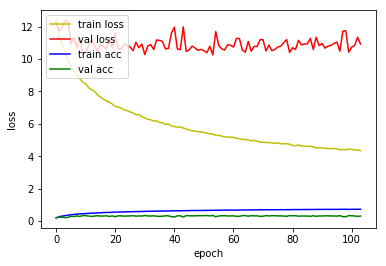

4815/4815 [==============================] - 3s 560us/sample - loss: 10.7863 - acc: 0.3113
Loss: 10.786306068681853 Accuracy: 0.31131878

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.2479 - acc: 0.3354
Epoch 00001: val_loss improved from inf to 3.55951, saving model to model/checkpoint/1D_CNN_2_conv_custom_BN_2_checkpoint/001-3.5595.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 4.2484 - acc: 0.3354 - val_loss: 3.5595 - val_acc: 0.3413
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0626 - acc: 0.6445
Epoch 00002: val_loss did not improve from 3.55951
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.0629 - acc: 0.6445 - val_loss: 4.8194 - val_acc: 0.3289
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1986 - acc: 0.7860
Epoch 00003: val_loss did not improve from 3.55951
36805/36805 [================

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2891 - acc: 0.9709
Epoch 00030: val_loss did not improve from 3.55951
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.2891 - acc: 0.9709 - val_loss: 8.1002 - val_acc: 0.3678
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3141 - acc: 0.9668
Epoch 00031: val_loss did not improve from 3.55951
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.3145 - acc: 0.9668 - val_loss: 8.2039 - val_acc: 0.3671
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2950 - acc: 0.9705
Epoch 00032: val_loss did not improve from 3.55951
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.2949 - acc: 0.9705 - val_loss: 8.0162 - val_acc: 0.3813
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3068 - acc: 0.9686
Epoch 00033: val_loss did not improve from 3.55951
36805/36805 [===========

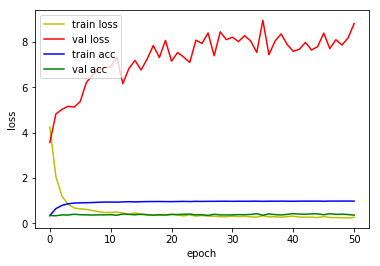

4815/4815 [==============================] - 4s 786us/sample - loss: 3.7863 - acc: 0.3173
Loss: 3.7862682504445964 Accuracy: 0.31734166

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2915 - acc: 0.4291
Epoch 00001: val_loss improved from inf to 2.05941, saving model to model/checkpoint/1D_CNN_3_conv_custom_BN_2_checkpoint/001-2.0594.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 2.2915 - acc: 0.4291 - val_loss: 2.0594 - val_acc: 0.4088
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9763 - acc: 0.7246
Epoch 00002: val_loss improved from 2.05941 to 2.02534, saving model to model/checkpoint/1D_CNN_3_conv_custom_BN_2_checkpoint/002-2.0253.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.9767 - acc: 0.7245 - val_loss: 2.0253 - val_acc: 0.5029
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4870 - ac

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0674 - acc: 0.9867
Epoch 00030: val_loss did not improve from 2.02534
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0678 - acc: 0.9867 - val_loss: 4.0537 - val_acc: 0.5006
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0765 - acc: 0.9836
Epoch 00031: val_loss did not improve from 2.02534
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0768 - acc: 0.9836 - val_loss: 3.8812 - val_acc: 0.5297
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9901
Epoch 00032: val_loss did not improve from 2.02534
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0562 - acc: 0.9901 - val_loss: 3.7376 - val_acc: 0.5334
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9902
Epoch 00033: val_loss did not improve from 2.02534
36805/36805 [===========

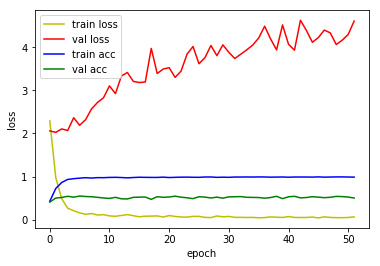

4815/4815 [==============================] - 4s 872us/sample - loss: 2.1049 - acc: 0.4687
Loss: 2.104940150633284 Accuracy: 0.4687435

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8262 - acc: 0.4738
Epoch 00001: val_loss improved from inf to 1.55467, saving model to model/checkpoint/1D_CNN_4_conv_custom_BN_2_checkpoint/001-1.5547.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.8263 - acc: 0.4738 - val_loss: 1.5547 - val_acc: 0.5246
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0889 - acc: 0.6755
Epoch 00002: val_loss improved from 1.55467 to 1.27578, saving model to model/checkpoint/1D_CNN_4_conv_custom_BN_2_checkpoint/002-1.2758.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.0891 - acc: 0.6755 - val_loss: 1.2758 - val_acc: 0.6366
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7648 - acc:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9941
Epoch 00029: val_loss did not improve from 1.24864
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0346 - acc: 0.9940 - val_loss: 2.0326 - val_acc: 0.6392
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9937
Epoch 00030: val_loss did not improve from 1.24864
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0337 - acc: 0.9936 - val_loss: 1.7600 - val_acc: 0.6760
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9954
Epoch 00031: val_loss did not improve from 1.24864
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0273 - acc: 0.9954 - val_loss: 1.7911 - val_acc: 0.6753
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9951
Epoch 00032: val_loss did not improve from 1.24864
36805/36805 [========================

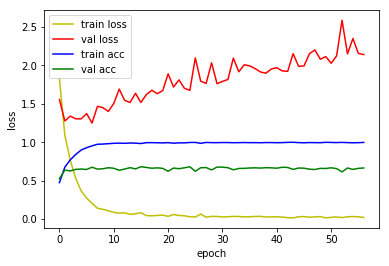

4815/4815 [==============================] - 5s 935us/sample - loss: 1.3484 - acc: 0.6471
Loss: 1.3483520427596902 Accuracy: 0.6471443

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6775 - acc: 0.5020
Epoch 00001: val_loss improved from inf to 1.40934, saving model to model/checkpoint/1D_CNN_5_conv_custom_BN_2_checkpoint/001-1.4093.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 1.6777 - acc: 0.5019 - val_loss: 1.4093 - val_acc: 0.5644
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0400 - acc: 0.6891
Epoch 00002: val_loss improved from 1.40934 to 1.02985, saving model to model/checkpoint/1D_CNN_5_conv_custom_BN_2_checkpoint/002-1.0299.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.0400 - acc: 0.6891 - val_loss: 1.0299 - val_acc: 0.7044
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7910 - acc

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9895
Epoch 00029: val_loss did not improve from 0.95749
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0474 - acc: 0.9895 - val_loss: 1.2069 - val_acc: 0.7547
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9932
Epoch 00030: val_loss did not improve from 0.95749
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0363 - acc: 0.9932 - val_loss: 1.3308 - val_acc: 0.7352
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9925
Epoch 00031: val_loss did not improve from 0.95749
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0392 - acc: 0.9925 - val_loss: 1.3818 - val_acc: 0.7342
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9950
Epoch 00032: val_loss did not improve from 0.95749
36805/36805 [===========

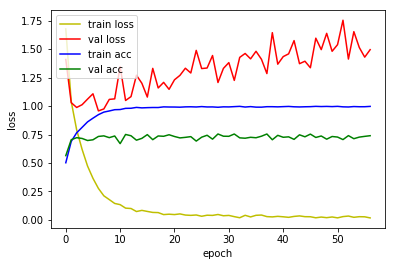

4815/4815 [==============================] - 5s 993us/sample - loss: 1.0188 - acc: 0.7082
Loss: 1.0188418635698122 Accuracy: 0.70820355

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6810 - acc: 0.4889
Epoch 00001: val_loss improved from inf to 1.61349, saving model to model/checkpoint/1D_CNN_6_conv_custom_BN_2_checkpoint/001-1.6135.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 1.6810 - acc: 0.4889 - val_loss: 1.6135 - val_acc: 0.4635
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0376 - acc: 0.6915
Epoch 00002: val_loss improved from 1.61349 to 0.95815, saving model to model/checkpoint/1D_CNN_6_conv_custom_BN_2_checkpoint/002-0.9582.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.0377 - acc: 0.6915 - val_loss: 0.9582 - val_acc: 0.7247
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8318 - a

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9865
Epoch 00028: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0632 - acc: 0.9865 - val_loss: 0.6699 - val_acc: 0.8367
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.9906
Epoch 00029: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0523 - acc: 0.9905 - val_loss: 0.6209 - val_acc: 0.8435
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9899
Epoch 00030: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0532 - acc: 0.9899 - val_loss: 0.6150 - val_acc: 0.8484
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9912
Epoch 00031: val_loss did not improve from 0.55473
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0184 - acc: 0.9976
Epoch 00058: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0184 - acc: 0.9976 - val_loss: 0.6171 - val_acc: 0.8651
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9957
Epoch 00059: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0235 - acc: 0.9957 - val_loss: 0.6923 - val_acc: 0.8570
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9931
Epoch 00060: val_loss did not improve from 0.55473
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0296 - acc: 0.9931 - val_loss: 0.6216 - val_acc: 0.8675
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9982
Epoch 00061: val_loss did not improve from 0.55473
36805/36805 [===========

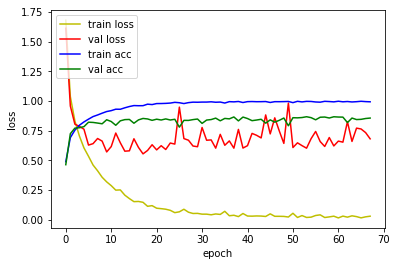

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6072 - acc: 0.8326
Loss: 0.6071557677175892 Accuracy: 0.83260643

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7100 - acc: 0.4775
Epoch 00001: val_loss improved from inf to 1.41256, saving model to model/checkpoint/1D_CNN_7_conv_custom_BN_2_checkpoint/001-1.4126.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 1.7099 - acc: 0.4776 - val_loss: 1.4126 - val_acc: 0.5588
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9754 - acc: 0.7123
Epoch 00002: val_loss improved from 1.41256 to 0.78696, saving model to model/checkpoint/1D_CNN_7_conv_custom_BN_2_checkpoint/002-0.7870.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.9755 - acc: 0.7123 - val_loss: 0.7870 - val_acc: 0.7743
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7270 - acc

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0659 - acc: 0.9841
Epoch 00026: val_loss did not improve from 0.28954
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0659 - acc: 0.9841 - val_loss: 0.3049 - val_acc: 0.9199
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9914
Epoch 00027: val_loss did not improve from 0.28954
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0443 - acc: 0.9914 - val_loss: 0.3499 - val_acc: 0.9071
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9850
Epoch 00028: val_loss did not improve from 0.28954
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0625 - acc: 0.9849 - val_loss: 0.3004 - val_acc: 0.9238
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9904
Epoch 00029: val_loss improved from 0.28954 to 0.25623, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9988
Epoch 00055: val_loss did not improve from 0.25623
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0097 - acc: 0.9988 - val_loss: 0.3022 - val_acc: 0.9269
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9973
Epoch 00056: val_loss did not improve from 0.25623
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0152 - acc: 0.9972 - val_loss: 0.2977 - val_acc: 0.9285
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9949
Epoch 00057: val_loss did not improve from 0.25623
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0221 - acc: 0.9949 - val_loss: 0.3519 - val_acc: 0.9201
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9953
Epoch 00058: val_loss did not improve from 0.25623
36805/36805 [========================

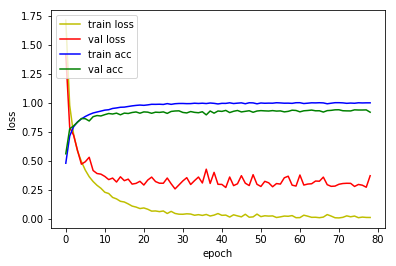

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3194 - acc: 0.9109
Loss: 0.31939273372617466 Accuracy: 0.91090345

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5113 - acc: 0.5452
Epoch 00001: val_loss improved from inf to 1.18224, saving model to model/checkpoint/1D_CNN_8_conv_custom_BN_2_checkpoint/001-1.1822.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 1.5113 - acc: 0.5453 - val_loss: 1.1822 - val_acc: 0.6443
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7029 - acc: 0.7993
Epoch 00002: val_loss improved from 1.18224 to 0.56464, saving model to model/checkpoint/1D_CNN_8_conv_custom_BN_2_checkpoint/002-0.5646.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.7031 - acc: 0.7993 - val_loss: 0.5646 - val_acc: 0.8437
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4810 - ac

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9933
Epoch 00027: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0310 - acc: 0.9933 - val_loss: 0.3363 - val_acc: 0.9180
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9935
Epoch 00028: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0294 - acc: 0.9935 - val_loss: 0.2105 - val_acc: 0.9460
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9967
Epoch 00029: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0189 - acc: 0.9966 - val_loss: 0.2209 - val_acc: 0.9397
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9907
Epoch 00030: val_loss did not improve from 0.16455
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9983
Epoch 00057: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0080 - acc: 0.9983 - val_loss: 0.1774 - val_acc: 0.9564
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.9994
Epoch 00058: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0041 - acc: 0.9994 - val_loss: 0.1755 - val_acc: 0.9569
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9970
Epoch 00059: val_loss did not improve from 0.16455
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0134 - acc: 0.9970 - val_loss: 0.1806 - val_acc: 0.9562
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9982
Epoch 00060: val_loss did not improve from 0.16455
36805/36805 [===========

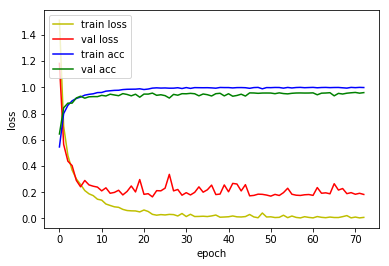

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2045 - acc: 0.9364
Loss: 0.20451734931298135 Accuracy: 0.9364486

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0841 - acc: 0.6678
Epoch 00001: val_loss improved from inf to 0.72409, saving model to model/checkpoint/1D_CNN_9_conv_custom_BN_2_checkpoint/001-0.7241.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 1.0840 - acc: 0.6678 - val_loss: 0.7241 - val_acc: 0.7934
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4252 - acc: 0.8721
Epoch 00002: val_loss improved from 0.72409 to 0.32088, saving model to model/checkpoint/1D_CNN_9_conv_custom_BN_2_checkpoint/002-0.3209.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.4252 - acc: 0.8721 - val_loss: 0.3209 - val_acc: 0.9026
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2861 - acc

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9979
Epoch 00028: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0101 - acc: 0.9979 - val_loss: 0.1711 - val_acc: 0.9557
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9926
Epoch 00029: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0267 - acc: 0.9926 - val_loss: 0.1639 - val_acc: 0.9553
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9992
Epoch 00030: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0065 - acc: 0.9992 - val_loss: 0.1433 - val_acc: 0.9632
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9988
Epoch 00031: val_loss did not improve from 0.14272
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9993
Epoch 00058: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0036 - acc: 0.9993 - val_loss: 0.1606 - val_acc: 0.9632
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9990
Epoch 00059: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0039 - acc: 0.9990 - val_loss: 0.2424 - val_acc: 0.9448
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9965
Epoch 00060: val_loss did not improve from 0.14272
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0115 - acc: 0.9964 - val_loss: 0.2298 - val_acc: 0.9509
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9946
Epoch 00061: val_loss did not improve from 0.14272
36805/36805 [===========

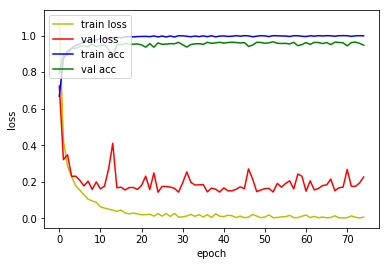

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2054 - acc: 0.9435
Loss: 0.2054227645647241 Accuracy: 0.9435099



In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_BN_2'.format(i)
    model = build_1d_cnn_custom_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_BN_2'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_BN_2 Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
batch_normalization_v1_55 (B (None, 1024000)           4096000   
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 20,480,656
Trainable params: 18,432,528
Non-trainable params: 2,048,128
_______________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.3484 - acc: 0.6471
Loss: 1.3483520427596902 Accuracy: 0.6471443

1D_CNN_5_conv_custom_BN_2 Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_69 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (None, 16000,

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3194 - acc: 0.9109
Loss: 0.31939273372617466 Accuracy: 0.91090345

1D_CNN_8_conv_custom_BN_2 Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_89 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   (None, 1600

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2054 - acc: 0.9435
Loss: 0.2054227645647241 Accuracy: 0.9435099
